This notebook compartmentalizes the section of the project in which data analytics were run.

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
import scipy.stats as stats

In [3]:
# Load the df_cleaned.csv file into a dataframe
df_cleaned = pd.read_csv('../data/processed/df_cleaned.csv')

# Display the first few rows of the dataframe to verify
df_cleaned.head()

,current_remote_work_time,preferred_remote_work_time,remote_collaboration_ease,remote_work_productivity,remote_prep_commute_time,remote_personal_time,remote_work_time,office_personal_time,office_prep_commute_time,office_work_time
0,90.0,90.0,4.0,1.5,0.5,3.5,8.0,2.0,2.0,8.0
1,20.0,20.0,4.0,0.8,0.0,3.0,7.0,3.0,2.0,7.0
2,100.0,100.0,5.0,1.0,0.0,3.0,9.0,1.0,1.0,9.0
3,70.0,50.0,5.0,1.0,0.0,3.0,7.0,2.0,1.0,8.0
4,100.0,90.0,5.0,1.5,0.0,5.0,8.0,4.0,2.0,8.0


Shapiro-Wilk Test (Remote Personal Time): p-value = 0.0000000000000112909371212910751420547814309705720221832254274163531704289198387414216995239257812500
Shapiro-Wilk Test (Office Personal Time): p-value = 0.0000000000000000097649331007962942605201429845527052651403448197526234453302862448254018090665340424


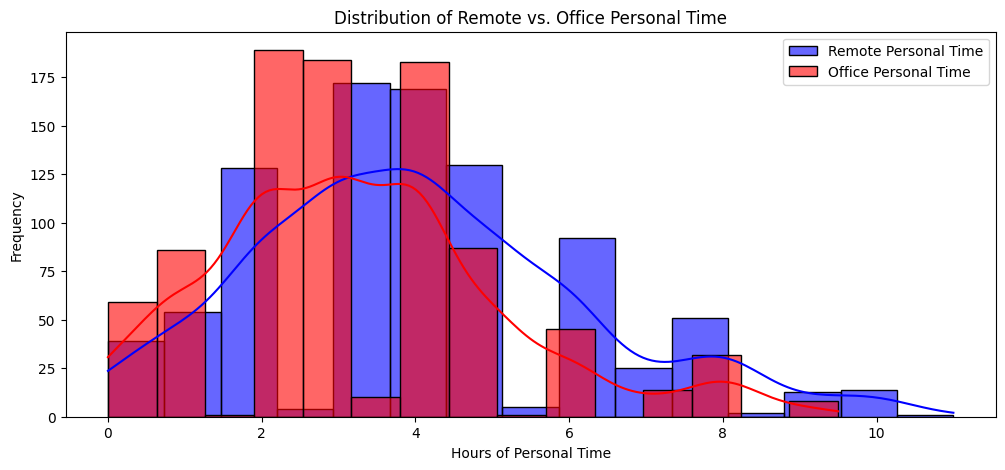

Levene’s Test for Equal Variance: p-value = 0.00011


In [ ]:
#Test for Normality and Equal Variance
# Shapiro-Wilk test for normality
# Levene's test for equal variance
#Tests failed for normality and equal variance, so we will use the Wilcoxon-signed rank test
remote_personal_time = df_cleaned["remote_personal_time"]
office_personal_time = df_cleaned["office_personal_time"]

shapiro_remote = stats.shapiro(remote_personal_time)
shapiro_office = stats.shapiro(office_personal_time)

print(f"Shapiro-Wilk Test (Remote Personal Time): p-value = {shapiro_remote.pvalue:.100f}")
print(f"Shapiro-Wilk Test (Office Personal Time): p-value = {shapiro_office.pvalue:.100f}")


plt.figure(figsize=(12,5))
sns.histplot(remote_personal_time, kde=True, color="blue", label="Remote Personal Time", bins=15, alpha=0.6)
sns.histplot(office_personal_time, kde=True, color="red", label="Office Personal Time", bins=15, alpha=0.6)
plt.title("Distribution of Remote vs. Office Personal Time")
plt.xlabel("Hours of Personal Time")
plt.ylabel("Frequency")
plt.legend()
plt.show()


levene_test = stats.levene(remote_personal_time, office_personal_time)

print(f"Levene’s Test for Equal Variance: p-value = {levene_test.pvalue:.5f}")

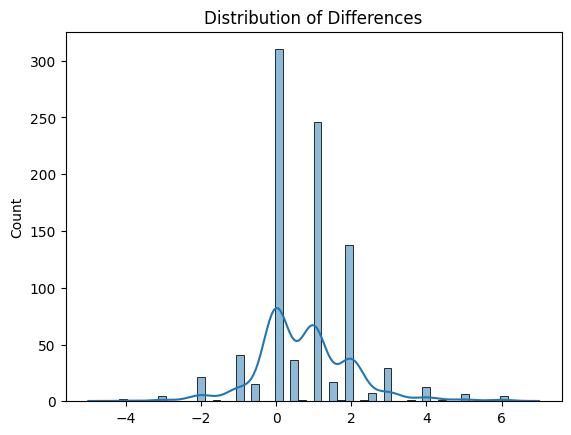

In [ ]:
# Check for normalit of differences
# Normality test for differences fails - use singed rank test
differences = remote_personal_time - office_personal_time
sns.histplot(differences, kde=True)
plt.title("Distribution of Differences")
plt.show()

In [10]:
from scipy.stats import binomtest

# Calculate the differences between paired samples
differences = remote_personal_time - office_personal_time

# Count the number of positive and negative differences
positive_differences = (differences > 0).sum()
negative_differences = (differences < 0).sum()

# Perform the Sign Test
n = positive_differences + negative_differences  # Total non-zero differences
result = binomtest(positive_differences, n=n, p=0.5, alternative='two-sided')

print(f"Sign Test: p-value = {result.pvalue:.74f}")

Sign Test: p-value = 0.00000000000000000000000000000000000000000000000000000000000000000000000122


In [11]:
import statsmodels.api as sm

# Create new columns for the differences
df_cleaned['personal_time_diff'] = df_cleaned['remote_personal_time'] - df_cleaned['office_personal_time']
df_cleaned['prep_commute_time_diff'] = df_cleaned['office_prep_commute_time'] - df_cleaned['remote_prep_commute_time']

# Define the independent variables (X) and dependent variable (y)
X = df_cleaned[['current_remote_work_time', 'remote_collaboration_ease', 'personal_time_diff', 'prep_commute_time_diff']]
y = df_cleaned['remote_work_productivity']

# Add a constant to the independent variables (for the intercept)
X = sm.add_constant(X)

# Fit the multiple linear regression model
model = sm.OLS(y, X).fit()

# Print the summary of the regression results
print(model.summary())

                               OLS Regression Results                               
Dep. Variable:     remote_work_productivity   R-squared:                       0.048
Model:                                  OLS   Adj. R-squared:                  0.044
Method:                       Least Squares   F-statistic:                     11.32
Date:                      Sun, 27 Apr 2025   Prob (F-statistic):           5.75e-09
Time:                              16:50:14   Log-Likelihood:                 103.67
No. Observations:                       899   AIC:                            -197.3
Df Residuals:                           894   BIC:                            -173.3
Df Model:                                 4                                         
Covariance Type:                  nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------